In [ ]:
  [Cam1 Image]    [Cam2 Image]    [Cam3 Image]
        |               |               |
       DINO Feature Extraction (각 뷰)
        |               |               |
 ----------------Cross-Attention----------------
                       |
             Multi-view Fused Feature
                       |
          -----------------------------
          |                           |
   Keypoint Head                  Angle Head
      (2D)                          (θ)
          |                           |
        ---------Forward Kinematics---------
                       |
                 3D Keypoints
                       |
            FK ↔ 2D Consistency Loss
                       |
                   (Optional)
                   solvePnP
                       |
                  Final 6D Pose

Shape of feature tensor: torch.Size([1, 1370, 768])
Shape of patch tokens after slicing: torch.Size([1, 1369, 768])


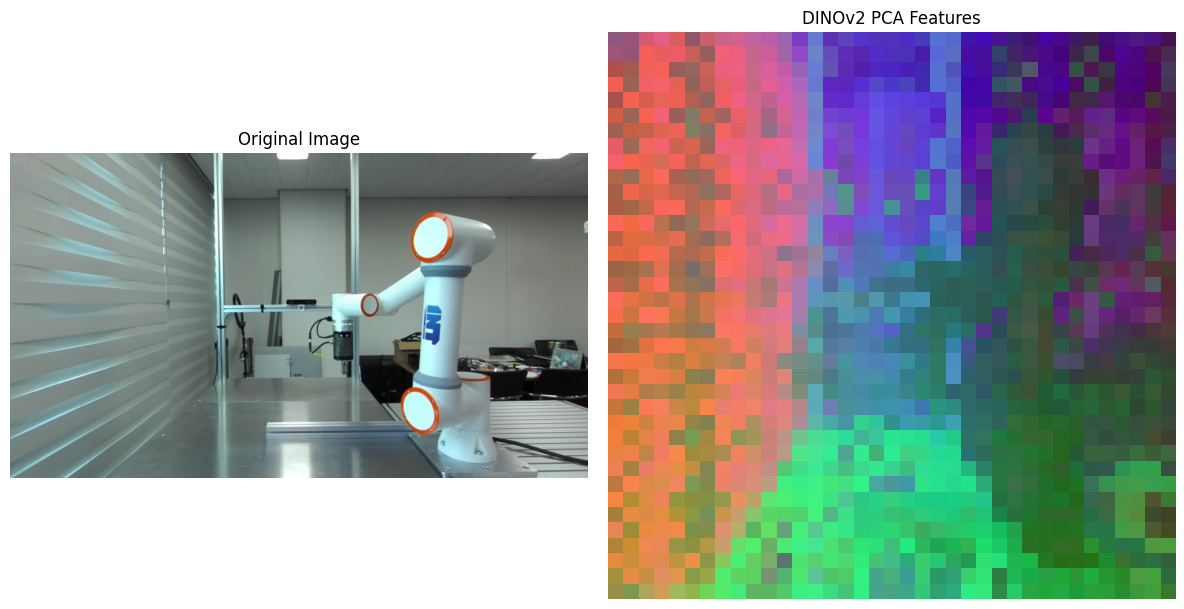

In [2]:
import torch
import timm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA

def visualize_dinov2_pca(image_path):
    """
    Loads an image, extracts DINOv2 features, and visualizes them using PCA.
    """
    # --- 1. Setup and Model Loading ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if not os.path.exists(image_path):
        print(f"❌ Error: Image not found at {image_path}")
        return

    # Load the DINOv2 model
    # Note: We set features_only=False to use the .forward_features method
    model = timm.create_model(
        'vit_base_patch14_dinov2.lvd142m',
        pretrained=True
    ).to(device).eval()

    # --- 2. Image Preprocessing ---
    config = model.default_cfg
    transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # --- 3. Feature Extraction ---
    with torch.no_grad():
        # model.forward_features returns the raw token tensor
        features = model.forward_features(input_tensor)
        
        # 💡 **FIX:** The output 'features' is a tensor, not a dict.
        # We slice it to skip the [CLS] token at the beginning.
        # shape: [batch, num_tokens, feature_dim]
        # We take all from batch, skip the 1st token, and take all features.
        patch_tokens = features[:, 1:, :]

    print(f"Shape of feature tensor: {features.shape}")
    print(f"Shape of patch tokens after slicing: {patch_tokens.shape}")

    # --- 4. PCA Application ---
    num_patches = patch_tokens.shape[1]
    
    # Reshape the tokens from [1, N, D] to [N, D] for PCA
    tokens_for_pca = patch_tokens.squeeze(0).cpu().numpy()
    
    pca = PCA(n_components=3)
    pca.fit(tokens_for_pca)
    pca_features = pca.transform(tokens_for_pca)
    
    # --- 5. Reshape for Visualization ---
    h = w = int(np.sqrt(num_patches))
    pca_image = pca_features.reshape(h, w, 3)
    
    # Normalize for color display
    pca_image = (pca_image - pca_image.min()) / (pca_image.max() - pca_image.min())

    # --- 6. Display Results ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(pca_image)
    axes[1].set_title('DINOv2 PCA Features')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
image_path1 = "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.339.jpg"
image_path3 = "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/right/zed_34850673_left_1748248620.325.jpg"
image_path2 = "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/top/zed_30779426_left_1748248620.350.jpg"
visualize_dinov2_pca(image_path3)

In [3]:
import torch
import torch.nn as nn
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os

# --- 1. DINOv2 Backbone Module ---
class DINOv2Backbone(nn.Module):
    """
    A wrapper for the DINOv2 model to extract patch tokens from an image.
    """
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        # Load the DINOv2 model
        self.model = timm.create_model(model_name, pretrained=True)
        # Get model configuration for preprocessing
        self.config = self.model.default_cfg
        self.transform = transforms.Compose([
            transforms.Resize(self.config['input_size'][-2:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config['mean'], std=self.config['std'])
        ])

    def forward(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")
        
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(next(self.model.parameters()).device)
        
        with torch.no_grad():
            # Extract features and skip the [CLS] token
            features = self.model.forward_features(input_tensor)
            patch_tokens = features[:, 1:, :]
        return patch_tokens

# --- 2. Multi-View Fusion Module using Cross-Attention ---
class MultiViewFusion(nn.Module):
    """
    Fuses features from multiple views using self-attention, which acts
    as cross-attention when tokens from all views are concatenated.
    """
    def __init__(self, feature_dim=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        # The core component: Multi-Head Attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Expects input shape [B, N, D]
        )
        # Standard Transformer components
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, view_features):
        # view_features: A list of tensors, e.g., [view1_tokens, view2_tokens, view3_tokens]
        # Each tensor has shape [1, NumPatches, FeatureDim]
        
        # Concatenate tokens from all views into a single sequence
        # Shape becomes [1, TotalNumPatches, FeatureDim]
        all_tokens = torch.cat(view_features, dim=1)
        
        # --- Self-Attention as Cross-Attention ---
        # The attention mechanism will calculate scores between every token pair.
        # This allows tokens from view 1 to attend to tokens from view 2 and 3,
        # effectively performing cross-view attention.
        attn_output, _ = self.attention(
            query=all_tokens,
            key=all_tokens,
            value=all_tokens
        )
        
        # First residual connection and layer norm
        x = self.layer_norm1(all_tokens + attn_output)
        
        # MLP part
        mlp_output = self.mlp(x)
        
        # Second residual connection and layer norm
        fused_features = self.layer_norm2(x + mlp_output)
        
        return fused_features

# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    backbone = DINOv2Backbone().to(device).eval()
    # The feature dimension of DINOv2-Base is 768
    fusion_module = MultiViewFusion(feature_dim=768).to(device).eval()

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.339.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/top/zed_30779426_left_1748248620.350.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/right/zed_34850673_left_1748248620.325.jpg"
    ]

    # --- Step A: Extract features for each view ---
    print("\n--- 1. Extracting features from each view ---")
    list_of_features = []
    for path in image_paths:
        print(f"Processing: {os.path.basename(path)}")
        patch_tokens = backbone(path)
        list_of_features.append(patch_tokens)
        print(f"  > Extracted feature shape: {patch_tokens.shape}")

    # --- Step B: Fuse features using the attention module ---
    print("\n--- 2. Fusing features with Multi-Head Cross-Attention ---")
    # The module expects a list of feature tensors
    fused_representation = fusion_module(list_of_features)

    # --- Step C: Show the final result ---
    print("\n--- 3. Final Fused Representation ---")
    print(f"Shape of the final fused feature map: {fused_representation.shape}")
    print("\nThis fused representation is now ready for the prediction heads (Keypoints and Angles).")

Using device: cuda

--- 1. Extracting features from each view ---
Processing: zed_38007749_left_1748248620.339.jpg
  > Extracted feature shape: torch.Size([1, 1369, 768])
Processing: zed_30779426_left_1748248620.350.jpg
  > Extracted feature shape: torch.Size([1, 1369, 768])
Processing: zed_34850673_left_1748248620.325.jpg
  > Extracted feature shape: torch.Size([1, 1369, 768])

--- 2. Fusing features with Multi-Head Cross-Attention ---

--- 3. Final Fused Representation ---
Shape of the final fused feature map: torch.Size([1, 4107, 768])

This fused representation is now ready for the prediction heads (Keypoints and Angles).


--- Testing KeypointHead ---
Shape of Predicted Heatmaps: torch.Size([4, 7, 128, 128])

--- Visualizing Heatmaps ---


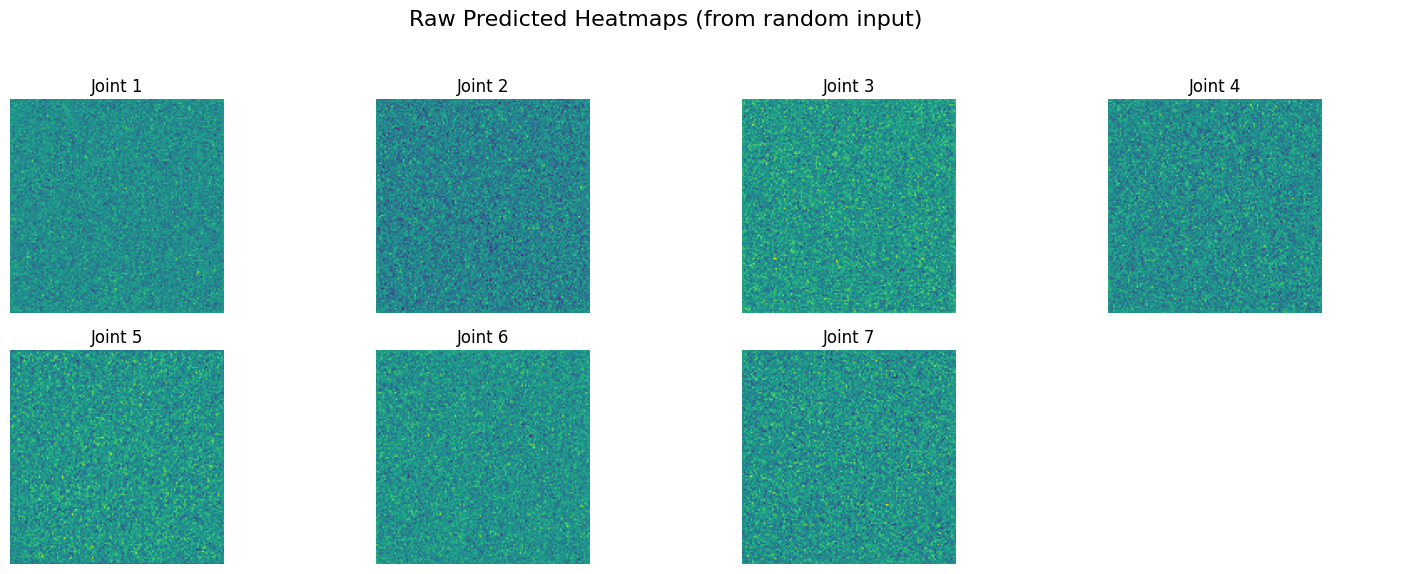

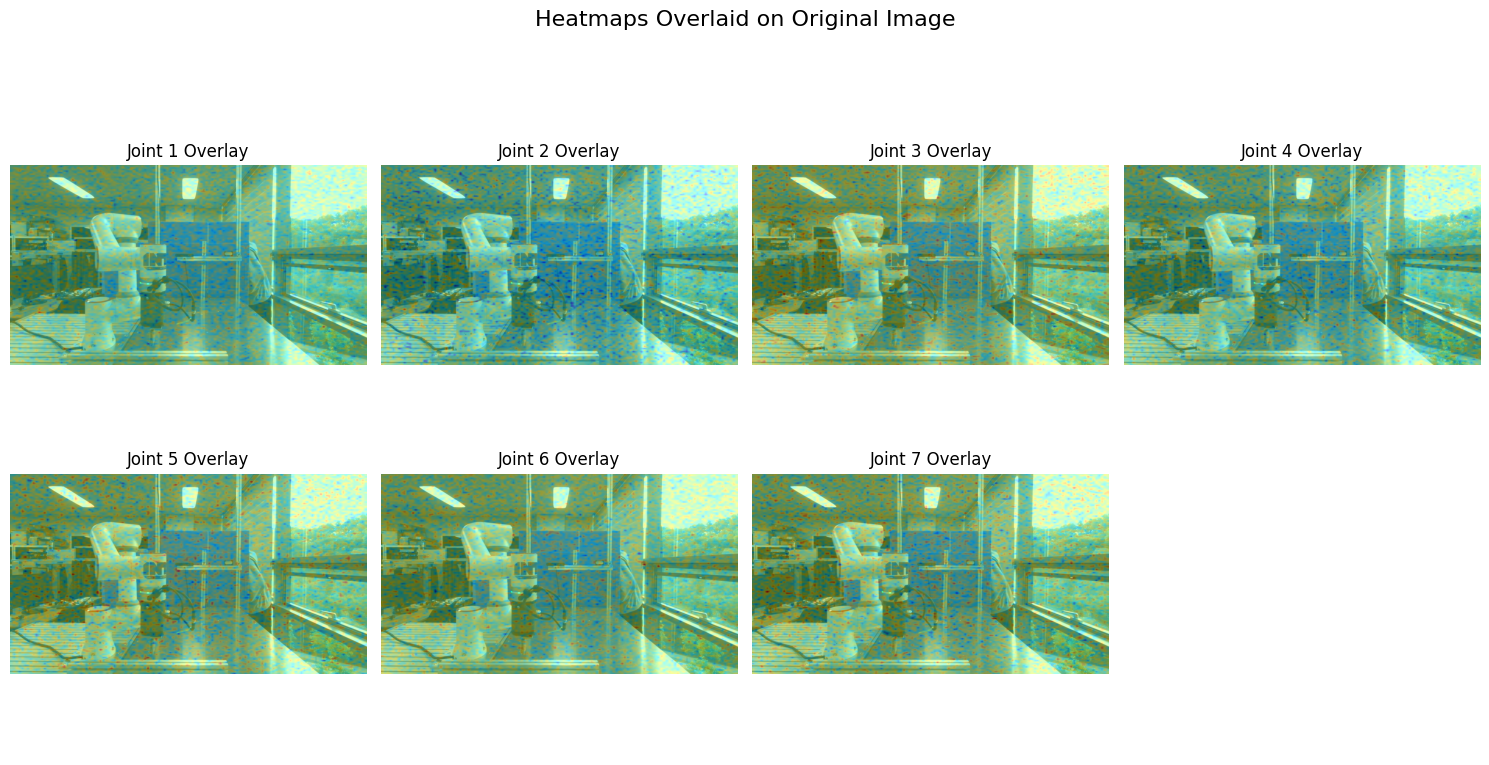

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# --- (Previous classes: AngleHead, KeypointHead go here) ---
# --- Constants for the example ---
NUM_JOINTS = 7
FEATURE_DIM = 768
TOTAL_TOKENS = 4107
HEATMAP_SIZE = (128, 128)

# --- 1. Joint Angle Prediction Head (Regression) ---
class AngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.LayerNorm(512), nn.Dropout(0.1),
            nn.Linear(512, 256), nn.GELU(), nn.LayerNorm(256), nn.Dropout(0.1),
            nn.Linear(256, num_joints)
        )
    def forward(self, fused_features):
        global_features = fused_features.mean(dim=1)
        return self.mlp(global_features)

# --- 2. 2D Keypoint Prediction Head (Heatmap) ---
class KeypointHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS, upsample_channels=[256, 128, 64]):
        super().__init__()
        self.reshape_size = 64
        layers = []
        in_channels = input_dim
        for out_channels in upsample_channels:
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels
        layers.append(nn.ConvTranspose2d(in_channels, num_joints, kernel_size=4, stride=2, padding=1))
        self.upsampler = nn.Sequential(*layers)

    def forward(self, fused_features):
        tokens_reshaped = fused_features[:, :self.reshape_size**2, :]
        b, n, d = tokens_reshaped.shape
        h = w = int(np.sqrt(n))
        feature_map = tokens_reshaped.permute(0, 2, 1).reshape(b, d, h, w)
        predicted_heatmaps = self.upsampler(feature_map)
        return F.interpolate(predicted_heatmaps, size=HEATMAP_SIZE, mode='bilinear', align_corners=False)

# --- 💡 NEW: Visualization Function 💡 ---
def visualize_heatmaps(heatmaps_tensor, original_image_path, num_joints=NUM_JOINTS):
    """
    Visualizes the raw heatmaps and overlays them on the original image.
    """
    # 1. Pre-process data
    # Select the first sample from the batch
    heatmaps = heatmaps_tensor[0].detach().cpu().numpy()
    # Load original image
    original_image = Image.open(original_image_path).convert('RGB')
    original_image_np = np.array(original_image)
    
    # --- Part A: Display Raw Heatmaps ---
    fig, axes = plt.subplots(2, (num_joints + 1) // 2, figsize=(15, 6))
    fig.suptitle('Raw Predicted Heatmaps (from random input)', fontsize=16)
    axes = axes.ravel()
    for i in range(num_joints):
        ax = axes[i]
        heatmap = heatmaps[i]
        ax.imshow(heatmap, cmap='viridis')
        ax.set_title(f'Joint {i+1}')
        ax.axis('off')
    # Hide any unused subplots
    for i in range(num_joints, len(axes)):
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Part B: Overlay Heatmaps on Original Image ---
    fig, axes = plt.subplots(2, (num_joints + 1) // 2, figsize=(15, 8))
    fig.suptitle('Heatmaps Overlaid on Original Image', fontsize=16)
    axes = axes.ravel()
    
    for i in range(num_joints):
        ax = axes[i]
        # Get a single heatmap
        heatmap = heatmaps[i]
        
        # Resize heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (original_image.width, original_image.height))
        
        # Normalize the heatmap to the range 0-255 and apply a colormap
        heatmap_normalized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized) + 1e-6)
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_normalized), cv2.COLORMAP_JET)
        
        # Convert original image from RGB to BGR for OpenCV
        original_image_bgr = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)
        
        # Blend the heatmap with the original image
        overlayed_image = cv2.addWeighted(original_image_bgr, 0.6, heatmap_colored, 0.4, 0)
        
        # Convert back to RGB for Matplotlib display
        overlayed_image_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(overlayed_image_rgb)
        ax.set_title(f'Joint {i+1} Overlay')
        ax.axis('off')
    # Hide any unused subplots
    for i in range(num_joints, len(axes)):
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Main Execution Logic ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Use a real image path for visualization
    original_image_path = "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.339.jpg"

    # Create a dummy fused tensor for demonstration
    batch_size = 4
    dummy_fused_tensor = torch.randn(batch_size, TOTAL_TOKENS, FEATURE_DIM).to(device)

    # --- Test Keypoint Head ---
    print("--- Testing KeypointHead ---")
    keypoint_head = KeypointHead().to(device)
    predicted_heatmaps = keypoint_head(dummy_fused_tensor)
    print(f"Shape of Predicted Heatmaps: {predicted_heatmaps.shape}")

    # --- Visualize the results ---
    print("\n--- Visualizing Heatmaps ---")
    visualize_heatmaps(predicted_heatmaps, original_image_path)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

# -----------------------------
# 1. Cross-Attention 모듈
# -----------------------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, feats_list):
        fused = feats_list[0]
        for feat in feats_list[1:]:
            attn_out, attn_weights = self.attn(fused, feat, feat)
            fused = fused + attn_out
        return fused, attn_weights  # attn_weights: [num_joints, num_views, tokens]

# -----------------------------
# 2. Keypoint Head
# -----------------------------
class KeypointHead(nn.Module):
    def __init__(self, dim, num_joints):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_joints*2)
        )
    
    def forward(self, x):
        pooled = x.mean(dim=1)
        keypoints = self.fc(pooled)
        keypoints = keypoints.view(x.size(0), -1, 2)
        return keypoints

# -----------------------------
# 3. Joint Angle Head
# -----------------------------
class AngleHead(nn.Module):
    def __init__(self, dim, num_joints):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_joints)
        )
    
    def forward(self, x):
        pooled = x.mean(dim=1)
        angles = self.fc(pooled)
        return angles

# -----------------------------
# 4. Forward Kinematics (Skeleton)
# -----------------------------
class ForwardKinematics:
    def __init__(self, dh_params):
        """
        dh_params: list of DH parameter tuples (theta, d, a, alpha) per joint
        """
        self.dh_params = dh_params

    def transform_matrix(self, theta, d, a, alpha):
        ct = np.cos(theta); st = np.sin(theta)
        ca = np.cos(alpha); sa = np.sin(alpha)
        return np.array([
            [ct, -st*ca, st*sa, a*ct],
            [st, ct*ca, -ct*sa, a*st],
            [0, sa, ca, d],
            [0,0,0,1]
        ], dtype=np.float32)

    def forward(self, angles):
        """
        angles: [B, num_joints]
        returns: 3D joint positions [B, num_joints, 3]
        """
        B, num_joints = angles.shape
        joint_positions = []
        for b in range(B):
            T = np.eye(4)
            joints_b = []
            for j in range(num_joints):
                theta, d, a, alpha = self.dh_params[j]
                T_joint = self.transform_matrix(theta + angles[b,j].item(), d, a, alpha)
                T = T @ T_joint
                joints_b.append(T[:3,3])
            joint_positions.append(joints_b)
        return torch.tensor(joint_positions, dtype=torch.float32)  # [B, num_joints, 3]

# -----------------------------
# 5. PnP Projection Layer
# -----------------------------
def project_3d_to_2d(joint_3d, camera_matrix, dist_coeffs=None, rvec=None, tvec=None):
    """
    joint_3d: [B, num_joints, 3] numpy array
    camera_matrix: 3x3 intrinsic
    returns: 2D projected points [B, num_joints, 2]
    """
    B, num_joints, _ = joint_3d.shape
    joint_2d_list = []
    for b in range(B):
        joints = joint_3d[b].numpy()
        if rvec is None:
            rvec_b = np.zeros((3,1))
        else:
            rvec_b = rvec[b]
        if tvec is None:
            tvec_b = np.zeros((3,1))
        else:
            tvec_b = tvec[b]
        pts_2d, _ = cv2.projectPoints(joints, rvec_b, tvec_b, camera_matrix, dist_coeffs)
        joint_2d_list.append(pts_2d.reshape(-1,2))
    return torch.tensor(np.stack(joint_2d_list), dtype=torch.float32)

# -----------------------------
# 6. Robot Pose Network
# -----------------------------
class RobotPoseNet(nn.Module):
    def __init__(self, backbone, dh_params, num_joints, num_views=3, camera_matrix=None):
        super().__init__()
        self.backbone = backbone
        self.num_views = num_views
        self.cross_attn = CrossAttentionFusion(dim=backbone.embed_dim)
        self.keypoint_head = KeypointHead(dim=backbone.embed_dim, num_joints=num_joints)
        self.angle_head = AngleHead(dim=backbone.embed_dim, num_joints=num_joints)
        self.fk = ForwardKinematics(dh_params)
        self.camera_matrix = camera_matrix  # [3,3] numpy
    
    def forward(self, images_list):
        feats_list = [self.backbone(img) for img in images_list]  # [B, N, D]
        fused_feat, attn_weights = self.cross_attn(feats_list)
        
        keypoints_2d = self.keypoint_head(fused_feat)  # [B, num_joints, 2]
        angles = self.angle_head(fused_feat)           # [B, num_joints]
        
        # Forward Kinematics → 3D joint positions
        joint_3d = self.fk.forward(angles)  # [B, num_joints, 3]
        
        # Projection to 2D (for consistency / PnP)
        if self.camera_matrix is not None:
            proj_2d = project_3d_to_2d(joint_3d, self.camera_matrix)  # [B, num_joints, 2]
        else:
            proj_2d = None
        
        return {
            'keypoints_2d': keypoints_2d,
            'angles': angles,
            'joint_3d': joint_3d,
            'proj_2d': proj_2d,
            'attn_weights': attn_weights
        }

# -----------------------------
# 7. Loss Function
# -----------------------------
def robot_pose_loss(pred, gt_keypoints=None, gt_angles=None, lambda_kp=1.0, lambda_angle=1.0, lambda_fk=1.0):
    loss = 0.0
    if gt_keypoints is not None:
        loss += lambda_kp * F.mse_loss(pred['keypoints_2d'], gt_keypoints)
    if gt_angles is not None:
        loss += lambda_angle * F.mse_loss(pred['angles'], gt_angles)
    if gt_keypoints is not None and pred['proj_2d'] is not None:
        loss += lambda_fk * F.mse_loss(pred['proj_2d'], gt_keypoints)  # FK consistency
    return loss